In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [2]:
import argparse
import torch
from torch import nn
import matplotlib.pyplot as plt
from stu import STU
import time
import random

Unable to import FlashFFTConv: No module named 'flashfftconv'. Falling back to PyTorch implementation.


In [3]:
from lds import *
from lds_utils import *

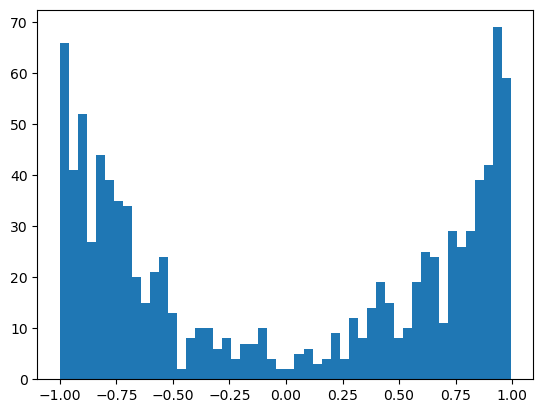

In [4]:
import matplotlib.pyplot as plt
_ = plt.hist(exponential_decay_init([1000], lam = 3), bins = 50)

In [5]:
import math
class LDS_LR(nn.Module):
    def __init__(self, state_dim, input_dim, output_dim, kx=5, rank = 50, lam = 1):
        super(LDS_LR, self).__init__()
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kx = kx
        self.h0 = nn.Parameter(torch.randn(state_dim))
        
        self.A = nn.Parameter(exponential_decay_init([state_dim], lam = lam))

        self.B1 = nn.Parameter(torch.randn(input_dim, rank) / input_dim) #each of these ranks could be different
        self.B2   = nn.Parameter(torch.randn(rank, state_dim) / math.sqrt(rank))

        self.C1 = nn.Parameter(torch.randn(state_dim, rank) / state_dim)
        self.C2   = nn.Parameter(torch.randn(rank, output_dim) / math.sqrt(rank))

        self.M2 = nn.Parameter(torch.randn(output_dim, rank, kx) / output_dim)
        self.M1   = nn.Parameter(torch.randn(rank, input_dim, kx) / math.sqrt(rank))
    

    def forward(self, inputs):
        device = inputs.device
        bsz, seq_len, _ = inputs.shape
        h_t = self.h0.expand(bsz, self.state_dim).to(device)
        A = self.A.flatten()
        
        all_h_t = []
        for t in range(seq_len):
            u_t = inputs[:, t, :]
            h_t = A * h_t + ((u_t @ self.B1) @ self.B2)
            all_h_t.append(h_t.unsqueeze(1))
        all_h_t = torch.cat(all_h_t, dim=1)
        lds_out = torch.matmul(all_h_t, self.C1)
        lds_out = torch.matmul(lds_out, self.C2)

        ar = compute_ar_x_preds_lr(self.M1, self.M2, inputs)
        return lds_out + ar

    def compute_loss(self, inputs, targets):
        mse_loss = nn.MSELoss()
        outputs = self(inputs)
        return mse_loss(outputs, targets)

    @classmethod
    def from_lds(cls, lds, rank= 50):
        ldslr = cls(lds.state_dim, lds.input_dim, lds.output_dim, lds.kx, rank = rank)
        
        with torch.no_grad():
            ldslr.h0.copy_(lds.h0)
            ldslr.A.copy_(lds.A)
            
            U, S, Vh = torch.linalg.svd(lds.B, full_matrices=False)
            U_r = U[:, :rank]
            S_r = S[:rank]
            V_r = Vh[:rank, :]
            ldslr.B1.copy_(U_r * torch.sqrt(S_r).unsqueeze(0))
            ldslr.B2.copy_(torch.sqrt(S_r).unsqueeze(1) * V_r)
            
            U, S, Vh = torch.linalg.svd(lds.C, full_matrices=False)
            U_r = U[:, :rank]
            S_r = S[:rank]
            V_r = Vh[:rank, :]
            ldslr.C1.copy_(U_r * torch.sqrt(S_r).unsqueeze(0))
            ldslr.C2.copy_(torch.sqrt(S_r).unsqueeze(1) * V_r)
            
            kx = lds.kx
            for i in range(kx):
                Mi = lds.M[:, :, i]
                U, S, Vh = torch.linalg.svd(Mi, full_matrices=False)
                U_r = U[:, :rank]
                S_r = S[:rank]
                V_r = Vh[:rank, :]
                ldslr.M2[:, :, i].copy_(U_r * torch.sqrt(S_r).unsqueeze(0))
                ldslr.M1[:, :, i].copy_(torch.sqrt(S_r).unsqueeze(1) * V_r)
        return ldslr


In [6]:
layer_i = 0
state_dim = 10000
batch_size = 2
epochs = 4000
seq_len = 512
kx = 3
lam = 1
lr = 0.0001

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the layer i weights
stu_layer_full = torch.load(f"../stu_layers/stu_layer_{layer_i}_500m_param_full.pt", map_location=device)
stu_layer_full.to(device)

# Initialize LDS model
# lds = LDS_LR(state_dim, 768, 768, kx, rank = 50, lam = lam).to(device)
lds = LDS(state_dim, 768, 768, kx, lam = lam).to(device)
optimizer = torch.optim.Adam(lds.parameters(), lr=lr)

# Training
lds_loss_values = []

best_loss = float('inf')

/tmp/ipykernel_4062196/936017912.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stu_layer_full = torch.load(f"../stu_layers/stu_layer_{layer_i}_500m_param_full.pt", ma

In [7]:
import time

start_time = time.time()  # Start the timer

for epoch in range(epochs):
    inputs = torch.randn(batch_size, seq_len, 768).to(device).to(torch.bfloat16)
    stu_outputs = stu_layer_full(inputs).to(device)

    optimizer.zero_grad()
    loss = lds.compute_loss(inputs.to(stu_outputs.dtype), stu_outputs)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lds.parameters(), max_norm=1)
    lds_loss_values.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        lds.A.data.clamp_(max=1, min=-1)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

    if epoch == 99:
        elapsed_time = time.time() - start_time
        print(f"Time taken for the first 100 epochs: {elapsed_time:.2f} seconds")

# Rank 768 is 66 seconds, Rank 50 is 16.76 seconds, normal LDS is 48 seconds
        
#With LDS_LR at rank = 50, kx = 3, state = 10k, lam = 1 after 100 epochs loss is 0.086, 200 is 0.084, 300 is 0.082
#With LDS_LR at rank = 300, kx = 3, state = 10k, lam = 1 after 100 epochs loss is 0.037, 200 is 0.02, 300 loss is 0.012
#With LDS_LR at rank = 768, kx = 3, state = 10k, lam = 1 after 100 epochs loss is 0.008, 200 is 0.0015, 300 loss is 0.00086

#With LDS at rank = 768, kx = 3, state = 10k, lam = 1 after 100 epochs loss is 0.0033, 200 is 0.00075, 300 loss is 0.00047

Epoch 0, Loss: 0.10263240337371826
Epoch 10, Loss: 0.08900611102581024
Epoch 20, Loss: 0.07389458268880844
Epoch 30, Loss: 0.05610746145248413
Epoch 40, Loss: 0.03890988975763321
Epoch 50, Loss: 0.02467184327542782
Epoch 60, Loss: 0.014636006206274033
Epoch 70, Loss: 0.008960101753473282
Epoch 80, Loss: 0.006007280200719833
Epoch 90, Loss: 0.004407826345413923
Time taken for the first 100 epochs: 50.12 seconds
Epoch 100, Loss: 0.003317310241982341
Epoch 110, Loss: 0.002577046398073435
Epoch 120, Loss: 0.0021130070090293884
Epoch 130, Loss: 0.0017338483594357967
Epoch 140, Loss: 0.0014739272883161902
Epoch 150, Loss: 0.0012616945896297693
Epoch 160, Loss: 0.0011090626940131187
Epoch 170, Loss: 0.0009791203774511814
Epoch 180, Loss: 0.0008936835220083594
Epoch 190, Loss: 0.0008279730100184679
Epoch 200, Loss: 0.0007599025848321617
Epoch 210, Loss: 0.0007059525232762098
Epoch 220, Loss: 0.0006716089555993676
Epoch 230, Loss: 0.0006316937506198883
Epoch 240, Loss: 0.000601499923504889
Epoc

KeyboardInterrupt: 

In [8]:
def init_lr_from_lds(lds, ldslr, rank=50):
    with torch.no_grad():
        ldslr.h0.copy_(lds.h0)
        ldslr.A.copy_(lds.A)
        
        U, S, Vh = torch.linalg.svd(lds.B, full_matrices=False)
        U_r = U[:, :rank]
        S_r = S[:rank]
        V_r = Vh[:rank, :]
        ldslr.B1.copy_(U_r * torch.sqrt(S_r).unsqueeze(0))
        ldslr.B2.copy_(torch.sqrt(S_r).unsqueeze(1) * V_r)
        
        U, S, Vh = torch.linalg.svd(lds.C, full_matrices=False)
        U_r = U[:, :rank]
        S_r = S[:rank]
        V_r = Vh[:rank, :]
        ldslr.C1.copy_(U_r * torch.sqrt(S_r).unsqueeze(0))
        ldslr.C2.copy_(torch.sqrt(S_r).unsqueeze(1) * V_r)
        
        kx = lds.kx
        for i in range(kx):
            Mi = lds.M[:, :, i]
            U, S, Vh = torch.linalg.svd(Mi, full_matrices=False)
            U_r = U[:, :rank]
            S_r = S[:rank]
            V_r = Vh[:rank, :]
            ldslr.M1[:, :, i].copy_(U_r * torch.sqrt(S_r).unsqueeze(0))
            ldslr.M2[:, :, i].copy_(torch.sqrt(S_r).unsqueeze(1) * V_r)


In [9]:
lds_lr = LDS_LR.from_lds(lds, rank = 768).to(device)

inputs = torch.randn(1, 100, 768).to(device).to(torch.bfloat16)
stu_outputs = stu_layer_full(inputs).to(device)

loss = lds_lr.compute_loss(inputs.to(stu_outputs.dtype), stu_outputs)
print(loss.item())

0.0002746510726865381


In [14]:
lds_output = lds(inputs.to(torch.float32))
lds_lr_output = lds_lr(inputs.to(torch.float32))

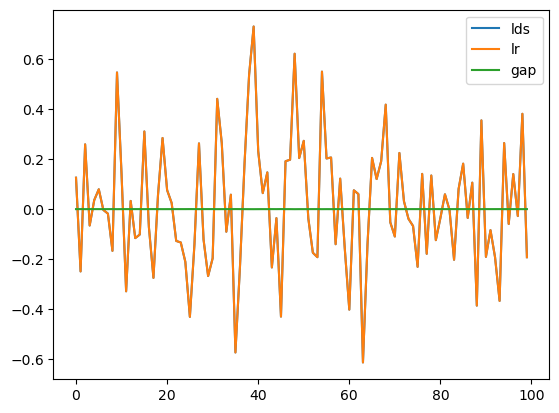

In [16]:
coord = 24
plt.plot(lds_output[0, :, coord].cpu().detach(), label = 'lds')
plt.plot(lds_lr_output[0, :, coord].cpu().detach(), label = 'lr')
plt.plot(lds_output[0, :, coord].cpu().detach() - lds_lr_output[0, :, coord].cpu().detach(), label = 'gap')
plt.legend()
plt.show()